# 1. 라이브러리 import 및 데이터 불러오기

In [1]:
import pandas as pd
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 시 데이터 불러오기
poem = pd.read_csv("../data/nlp_poem.csv", index_col=False)
poem.head()


,author,title,content
0,이순,가을에는 이런 사람이 그립다,수평선이나 지평선 보다<br>더 깊고 아득한 눈빛으로<br>세상의 그리움 다 깨워서...
1,문정희,가을 노트,<br><br><br>그대 떠나간 후<br>나의 가을은<br>조금만 건드려도<br>...
2,이순,가을비 오는 날은,<br>자정이 되어 간신히 그치는 비<br>간신히 버리는 그리움<br>그동안 너무 ...
3,이성선,가을 편지,<br>잎이 떨어지고 있습니다<br>원고지처럼 하늘이 한 칸씩<br>비어 가고 있습...
4,박제영,가을에는,가을에는 잠시 여행을 떠날 일이다<br>그리 수선스러운 준비는 하지 말고<br>그리...


# 2. 데이터 전처리

In [3]:
# 불용어
stopwords = [
    '하다', '이다', '아니다', '않다', '되다', '있다', '없다', '싶다', '알다', '보다', '마다', '같다', '지다', '가다',
    '나', '그대', '당신', '우리', '이', '그', '저', '무엇', '이런', '저런', '그런', '것',
    '하나', '모든', '때문', '다음', '위해', '사람', '줄', '못', '그리다'
]

In [4]:
# 토큰화 함수
def tokenize(text):
    okt = Okt()

    # 줄바꿈(<br>) 제거
    text = text.replace("<br>", " ")

    # 형태소(품사) 분석 - 정규화有, 어간추출有
    okt_pos = okt.pos(text, norm=True, stem=True)

    # 특정 품사(명사, 동사, 형용사)만 사용
    lst_word = [word for word, pos in okt_pos if pos in ["Noun", "Adjective", "Verb"]]

    # 불용어 제거
    lst_word = [word for word in lst_word if word not in stopwords]

    # list를 이어 string으로 반환
    str_word = " ".join(lst_word)

    return str_word


In [5]:
# 시 내용에 토큰화 적용
content = poem["content"]
content_tokens = content.apply(tokenize)
content_tokens.head()

0    수평선 지평선 더 깊다 아득하다 눈빛 세상 그리움 깨우다 다른 불행하다 사랑 유심 ...
1    떠나가다 후 가을 조금 건드리다 우수수 몸 떨다 다한 말 다한 노래 끄다 씨앗 가슴...
2    자정 되어다 그치다 비 버리다 그리움 그동안 많다 버리다 허다 세월 지나 돌아보다 ...
3    잎 떨어지다 원고지 하늘 칸 비어 빈 곳 맑은 영혼 잉크 물 편지 써다 보내다 사랑...
4    가을 잠시 여행 떠나다 일이 수선스럽다 준비 가깝다 멀다 데 가을 스스로 높다 푸른...
Name: content, dtype: object

# 3. 자주 등장하는 단어 계산, TF-IDF
- 각 시마다 빈도수 높은 5개의 단어들만 살리고 나머지 단어는 0으로

In [6]:
tfidf_vectorizer = TfidfVectorizer()

# 벡터화
# 토큰화된 시는 tfidf_vectorizer.vocablurary_ 에 저장됨
vector_matrix = tfidf_vectorizer.fit_transform(content_tokens)

# 타입 변경: scipy.sparse.csr.csr_matrix → numpy.ndarray → pandas.core.frame.DataFrame
df_data = pd.DataFrame(vector_matrix.toarray())
df_data.head()

,0,1,2,3,4,5,6,7,8,9,...,14505,14506,14507,14508,14509,14510,14511,14512,14513,14514
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# 인덱스로 단어 추출 (tfidf_vectorizer.vocablurary_에서)
def index_to_word(index):
    vocabs = tfidf_vectorizer.vocabulary_
    for word, word_idx in vocabs.items():
        if word_idx == index:
            return word

In [8]:
df = pd.DataFrame(columns=range(df_data.shape[1]))

# 행 길이 만큼 반복. 현재 행이 시이므로 시 개수 만큼 반복.
for row_index in range(len(df_data)):
    # 해당 행(row)
    row = df_data.loc[row_index]

    # 내림차순으로 5개만 추출
    top5_in_a_row = row.sort_values(ascending=False)[0:5]

    str_index = ""
    for key, value in top5_in_a_row.items():
        if value < 0.005:
            break
        else:
            str_index = str_index + index_to_word(key) + ","

    df.loc[str_index] = row.values

# 4. 주 성분 분석, PCA, 

## 4-1. 2차원

No handles with labels found to put in legend.


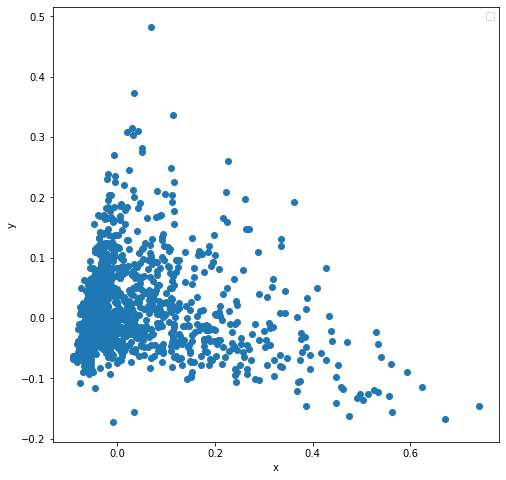

,0,1
"그렇다,가을,눈부시다,사랑,문득,",0.167861,0.111558
"우수수,다한,건드리다,떠나가다,담다,",0.080465,-0.008916
"가을비,버리다,자정,떨다,지나,",-0.022557,0.104992
"비어,보내다,잉크,원고지,전해,",0.031740,0.049502
"가을,일이,여행,수선스럽다,찬찬하다,",-0.028757,0.085419


In [9]:
pca = PCA(n_components=2)

poem_pca = pd.DataFrame(pca.fit_transform(df), index=df.index)
plt.figure(figsize=(8, 8))
plt.scatter(poem_pca[0], poem_pca[1])
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
poem_pca.head()

No handles with labels found to put in legend.


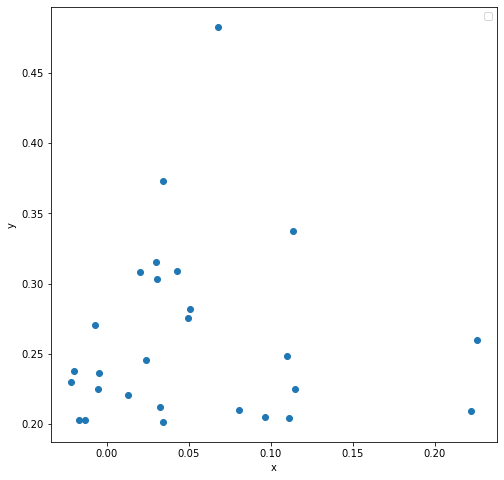

,0,1
"모습,가꾸다,살리다,가슴속,틀다,",0.012918,0.220710
"잊다,상처,풋사랑,그립다,낫다,",0.080803,0.209709
"그립다,아프다,살다,모르다,버리다,",0.029754,0.315716
"꺼내다,하늘,마음,그윽히,묻다,",-0.007192,0.270226
"한가지,변치,살다,거꾸로,비록,",0.110132,0.248443
"좋다,형편,가지다,어떠하다,용서,",0.019951,0.308571
"좋다,친구,살피,서로,한아름,",0.050766,0.281559
"그리움,자기,그립다,방법,사랑,",0.222226,0.209030
"멈추다,마음,마음먹다,흐르다,우울하다,",0.096525,0.205158
"하늘,보아,힘들다,가야,쓰러지다,",-0.021908,0.230234


In [10]:
poem_pca_y_high = poem_pca[(poem_pca[1] >= 0.2)]
plt.figure(figsize=(8, 8))
plt.scatter(poem_pca_y_high[0], poem_pca_y_high[1])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()
poem_pca_y_high

No handles with labels found to put in legend.


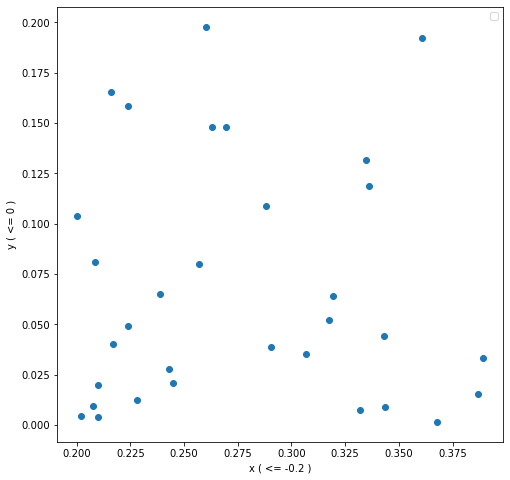

,0,1
"소유,갖다,엄마,사랑,주다,",0.306916,0.035187
"고맙다,소중하다,사랑,내다,존경,",0.244955,0.020928
"돌아서다,사랑,한평생,리라,힘없다,",0.287987,0.108603
"깊숙하다,마음,사랑,꽃씨,영토,",0.260324,0.197847
"행복하다,사랑,바라보다,앞날,가르치다,",0.335842,0.118664
"여러,생각,떠나다,사랑,헛된,",0.210060,0.003998
"사랑,느끼다,두렵다,하든,의무,",0.342997,0.044270
"인생,행복하다,사랑,행복,허무하다,",0.317318,0.052098
"꽃지,맞장구,귓바퀴,사랑,우정,",0.201970,0.004351
"가끔,이루어지다,사랑,뽀오얀,한가롭다,",0.208509,0.080975


In [11]:
poem_pca_xy_middle = poem_pca[
    (poem_pca[0] >= 0.2) & (poem_pca[0] <= 0.4) & (poem_pca[1] >= 0) & (poem_pca[1] <= 0.2)
]
plt.figure(figsize=(8, 8))
plt.scatter(poem_pca_xy_middle[0], poem_pca_xy_middle[1])
plt.legend()
plt.xlabel("x ( <= -0.2 )")
plt.ylabel("y ( <= 0 )")
plt.show()
poem_pca_xy_middle

No handles with labels found to put in legend.


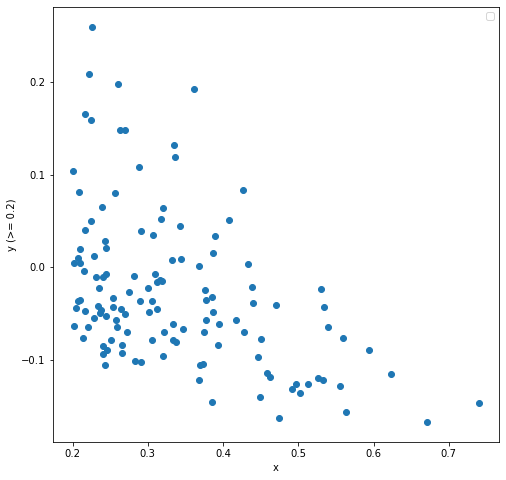

,0,1
"사랑,가장,절실,비우다,만큼,",0.593548,-0.089261
"소유,갖다,엄마,사랑,주다,",0.306916,0.035187
"고맙다,소중하다,사랑,내다,존경,",0.244955,0.020928
"돌아서다,사랑,한평생,리라,힘없다,",0.287987,0.108603
"사랑,아픔,겪다,아름답다,여러가지,",0.559325,-0.076966
...,...,...
"미안하다,사랑,애드벌룬,군락,해오다,",0.243447,-0.105395
"사랑,여자,누렁이,두더지,미워하다,",0.502814,-0.136202
"순도,용광로,이만,독성,결의,",0.220172,-0.065208
"사랑,말다,피하,나무라다,그렇다,",0.448463,-0.140499


In [12]:
poem_pca_x_big = poem_pca[(poem_pca[0] >= 0.2)]
plt.figure(figsize=(8, 8))
plt.scatter(poem_pca_x_big[0], poem_pca_x_big[1])
plt.legend()
plt.xlabel('x')
plt.ylabel('y (>= 0.2)')
plt.show()
poem_pca_x_big

## 4-2. 3차원

In [13]:
import plotly.express as px

pca = PCA(n_components=3)
poem_pca3d = pd.DataFrame(pca.fit_transform(df), index=df.index)

fig = px.scatter_3d(poem_pca3d, x=0, y=1, z=2)
fig.show()


In [14]:
poem_pca_z_middel = poem_pca3d[(poem_pca3d[2] >= 0.3)]

# 정렬이 0~2가 아니라 그녀, 좋다에서 되고 있음. 수정 필요.
poem_pca_z_middel.sort_values(by=2, ascending=True)

,0,1,2
"그녀,친구,좋다,이별,절대로,",0.138391,0.095907,0.366755
"좋다,형편,가지다,어떠하다,용서,",0.019949,0.312028,0.390440
